# YOLO ROI Crop Analaysis
Comparing torchscript vs actual model variant.

In [1]:
import torch
import torchvision
from math import ceil

import numpy as np

from ultralytics import YOLO
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as T

import os
import random

In [2]:
PATH_TO_MODEL = os.path.join(os.getcwd(), "..", "weights", "yolo", "train", "weights", "best.pt")
PATH_TO_SCRIPT = os.path.join(
    os.getcwd(), "..", "weights", "yolo", "train", "weights", "best.torchscript")
PATH_TO_IMG = os.path.join(os.getcwd(), "..", "dataset", "Images")

In [3]:
def get_random_image(path=PATH_TO_IMG):
    """
    Returns a tuple (img_path, image), where:
     - img_path is the full filesystem path to a randomly chosen image
     - image is a PIL.Image opened in RGB mode
    """
    # List all image files in the directory
    image_files = [
        f for f in os.listdir(path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    if not image_files:
        raise FileNotFoundError(f"No images found in {path}")

    # Pick one at random
    chosen = random.choice(image_files)
    img_path = os.path.join(path, chosen)

    # Load and return
    image = Image.open(img_path).convert('RGB')
    return img_path, image


def show_pil_image(image, title=None):
    """
    Renders a PIL.Image in a Matplotlib figure.

    Args:
        image (PIL.Image): The image to display.
        title (str, optional): Title for the plot.
    """
    plt.figure(figsize=(6, 6))
    plt.imshow(image)        # Matplotlib understands PIL Images directly
    if title:
        plt.title(title)
    plt.axis('off')          # hide axes ticks
    plt.tight_layout()
    plt.show()

## Model Section

In [4]:
def apply_roi_and_crop(model, image: Image.Image) -> Image.Image:
        # Run YOLO on the PIL image
        results = model(image, verbose=False)
        result = results[0]
        if not result.boxes:
            # no boxes detected → return full strip
            return image

        # pick the box with highest confidence
        boxes = result.boxes
        confidences = boxes.conf.cpu()
        best_idx = int(torch.argmax(confidences))
        best_conf = float(confidences[best_idx])

        # if top confidence is too low, skip cropping
        if best_conf < 0.3:
            return image

        # otherwise, crop the strip
        x1, y1, x2, y2 = boxes.xyxy[best_idx].cpu().numpy().astype(int)
        return image.crop((x1, y1, x2, y2))

In [5]:
model = YOLO(PATH_TO_MODEL).eval()

In [6]:
img_path, img = get_random_image()

with torch.no_grad():
    cropped = apply_roi_and_crop(model, img)

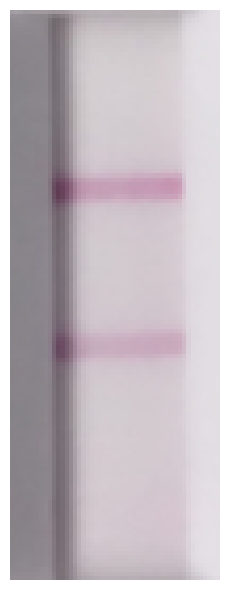

In [7]:
show_pil_image(cropped)

In [8]:
model.export(
            format="torchscript",
            optimize=True,
            nms=True,
            batch=1,
            device="cpu",
            mode="export"
        )

Ultralytics 8.3.136 🚀 Python-3.12.9 torch-2.6.0 CPU (Apple M1 Pro)

PyTorch: starting from '/Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments/../weights/yolo/train/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (18.3 MB)

TorchScript: starting export with torch 2.6.0...
TorchScript: optimizing for mobile...
TorchScript: export success ✅ 1.9s, saved as '/Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments/../weights/yolo/train/weights/best.torchscript' (36.1 MB)

Export complete (2.2s)
Results saved to /Users/sriharikarthickn/Developer/Projects/dissertation-model/src/weights/yolo/train/weights
Predict:         yolo predict task=detect model=/Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments/../weights/yolo/train/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=/Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments

'/Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments/../weights/yolo/train/weights/best.torchscript'

## Script Section

In [9]:
# script = torch.jit.load(PATH_TO_SCRIPT)
script = YOLO(PATH_TO_SCRIPT)

WARNING ⚠️ Unable to automatically guess model task, assuming 'task=detect'. Explicitly define task for your model, i.e. 'task=detect', 'segment', 'classify','pose' or 'obb'.


In [10]:
img_path, img = get_random_image()

with torch.no_grad():
    results = script(img)

Loading /Users/sriharikarthickn/Developer/Projects/dissertation-model/src/experiments/../weights/yolo/train/weights/best.torchscript for TorchScript inference...

0: 640x640 1 test_window, 140.6ms
Speed: 1.6ms preprocess, 140.6ms inference, 0.1ms postprocess per image at shape (1, 3, 640, 640)


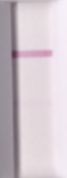

In [11]:
apply_roi_and_crop(model, img)

In [12]:
script = torch.jit.load(PATH_TO_SCRIPT)

In [17]:
img_path, img = get_random_image()

transform = T.Compose([
    T.Resize((640, 640)),   # -> exactly 640×640
    T.ToTensor(),
])

tensor = transform(img)
tensor = tensor.unsqueeze(0)

# — Run forward pass —
with torch.no_grad():
    results = script(tensor)
    results = results[0]


In [14]:
def crop_and_show(results, img, img_size = 640):
    pil = img.resize((img_size, img_size))

    # 2) Filter by confidence
    mask = results[:, 4] > 0.3
    dets = results[mask]

    if dets.shape[0] == 0:
        print("No detections above confidence threshold")
        return

    # 3) Crop
    crops = []
    for x1, y1, x2, y2, conf, cls in dets.tolist():
        # make ints & clamp
        x1, y1 = int(max(x1, 0)), int(max(y1, 0))
        x2 = int(min(x2, img_size))
        y2 = int(min(y2, img_size))
        if x2 <= x1 or y2 <= y1:
            continue
        crops.append(pil.crop((x1, y1, x2, y2)))

    # 4) Show in a grid
    n = len(crops)
    cols = min(n, 4)
    rows = ceil(n/cols)
    plt.figure(figsize=(cols*3, rows*3))
    for i, c in enumerate(crops, 1):
        ax = plt.subplot(rows, cols, i)
        ax.imshow(c)
        ax.set_title(f"#{i}")
        ax.axis("off")
    plt.tight_layout()
    plt.show()

In [15]:
print(results)

tensor([[321.0381, 249.2455, 388.8344, 400.8065,   0.7731,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        ...,
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000],
        [  0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000]])


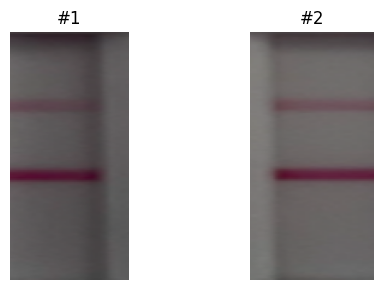

In [18]:
crop_and_show(results, img)